In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
from numpy.polynomial import Polynomial
from scipy.optimize import curve_fit
import numpy as np
from numpy.polynomial import Polynomial
import seaborn as sns
from pymoo.indicators.hv import HV
import os
import scikit_posthocs as sp
import traceback

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('seaborn')

<ipython-input-1-5d6ed61fb0cb>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
max_expr_size = None
max_gen = None
max_size = 10
max_complexity = 1

dataset_filename_fronts = defaultdict(lambda: defaultdict(list))

translation_dict = {
"SO":"SO",
"MO": "MO",
"MO_equalclustersize": "5 x population size",
"MO_balanced": "Balanced k-leader",
"MO_k2": "Balanced k-2-Leader",
"MO_frac1": "Restricted Donor Population",
"MO_equalclustersize_balanced_frac1": "",
"MO_equalclustersize_k2_frac1": "Balanced k-2-Leader restricted donor population",
"MO_equalclustersize_k2_frac1_noadf":"",
"MO_equalclustersize_balanced_discount":"",
"MO_equalclustersize_balanced_frac1_discount":"",
"MO_equalclustersize_k2_noadf":"",
"MO_equalclustersize_k2":"",
"MO_equalclustersize_balanced":"",
"MO_equalclustersize_frac1":"",
"tree_7":"",
"tree_42":"",
"tree_44":"",
"MO_nocluster": "MO without clustering",
"MO_k2_frac1":"MO_k2_frac1"
}

In [3]:


def statistics_latex(hv_list, dataset, appendix):
    try:
        print("#"*20, dataset, appendix, "#"*20)
        print(sorted(list(hv_list.keys())))

        stri = ""
        for x in ["{0:.3f} $\\pm$ {1:.3f}".format(np.mean(hv_list[k]), np.std(hv_list[k])) for k in sorted(list(hv_list.keys()))]:
            stri += x + " & "
        print(stri)
        
        print([len(hv_list[k][0]) for k in sorted(list(hv_list.keys()))])
        x = sp.posthoc_wilcoxon([hv_list[k][0] for k in sorted(list(hv_list.keys()))], p_adjust="Holm")
        print(x)
        print("#"*20)
        return x
    except Exception as e:
        print("stats", e)
        pass

def statistics(hv_list, dataset, appendix):
    print("#"*20, dataset, appendix, "#"*20)

    for k in hv_list.keys():
        print(k, np.mean(hv_list[k]))


def make_plots(d, folder, x_index, appendix):
    
    for el in experiments:
        fig = plt.figure()
        plt.title("Dataset: {}".format(dataset.capitalize()))
        markers = ['o', 'x', '^','s']
        x = []

        hv_list = defaultdict(list)

        for key in d.keys():
            if key in el:
                x = d[key][x_index]
                y = d[key][1]

                gens = np.mean(d[key][2])
                
                print(x_index, max_size, max_complexity)
                #hvs = calc_hv(dataset_filename_fronts, dataset, key, x_index, max_size)
                hvs = calc_hv_3d(dataset_filename_fronts, dataset, key, x_index, max_size, max_complexity)
                
                print(hvs)

                hv_list[key].append(hvs)

                coefficients = np.polyfit(x, y, deg=5)  # Adjust the degree of polynomial as needed
                poly = np.poly1d(coefficients)

                # Generate points for the fitted curve
                x_fit = np.linspace(min(x), max(x), 1000)
                y_fit = poly(x_fit)


                # Plot scatter plot and line plot
                color = sns.color_palette()[int(el.index(key))]  # Get color from tab10 colormap
                marker = markers[int(el.index(key))]
                
                print("MEAN ", key, np.mean(hvs))

                plt.scatter(x, y, alpha=0.4, s=18, label=translation_dict[key] + " Average HV={0:.3f}, \n Average generations={1:.1f}".format(np.mean(hvs), gens), color=color, marker=marker)
                #plt.plot(x_fit, y_fit, c=color, alpha=0.5)

                # Commented out, because extreme slow
                # print("nondom")
                # nondom_list_x, nondom_list_y = non_dom(x,y)
                # plt.plot(nondom_list_x, nondom_list_y, linestyle='--', c=color,alpha=0.5)
                # print("done")

        statistics(hv_list, dataset, appendix)      

        if(len(x)>0):
            plt.xlim(0.5,None)
            plt.xlabel(r'$R^2$')
            plt.ylabel('Expression size')
            # plt.yscale('log', base=5)
            plt.legend()
            fig.set_size_inches(10, 10)

            #plt.gca().set_aspect('equal')

            directory = "./results/plots/" + folder
            isExist = os.path.exists(directory)
            if not isExist:
                os.makedirs(directory)

            if max_gen is None:
                plt.savefig(directory + "/{}_{}.png".format(dataset + "".join(el), appendix), dpi=600, bbox_inches='tight')
            else:
                plt.savefig(directory + "/{}_{}gen_{}.png".format(dataset + "".join(el), max_gen, appendix), dpi=600, bbox_inches='tight')
            plt.show()
        plt.close()

def get_mses(d, folder, x_index, appendix):
    pass





In [4]:
experiments = [
    ['SO','MO'],
    #['SO','MO_equalclustersize_k2_frac1'],
    #['MO_equalclustersize', 'MO_balanced', 'MO_k2', 'MO_frac1'], 
    #['MO_equalclustersize_frac1', 'MO_equalclustersize_balanced', 'MO_equalclustersize_k2'], 
    #['MO_equalclustersize_balanced_frac1','MO_equalclustersize_k2_frac1','SO'],
    #['MO_equalclustersize_k2_frac1_noadf, MO_equalclustersize_k2_frac1'],
    #['MO_equalclustersize_balanced_discount','MO_equalclustersize_k2_frac1','SO','MO_equalclustersize_balanced_frac1_discount'],
    #['MO_equalclustersize_k2_noadf','MO_equalclustersize_k2'],
    #['tree_7','tree_42','tree_44'],
    #["MO","MO_nocluster"]
    ]


big_list = []
for sublist in experiments:
    big_list.extend(sublist)






#
for dataset in ["air", "bike", "concrete","dowchemical","tower", "synthetic_dataset"]:
#for dataset in ["Concrete"]:

    d = defaultdict(lambda: defaultdict(list))
    c = defaultdict(int)
    time = defaultdict(float)

    folder = "multi"
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):
        nr = filename.split("/")[-1].split("_")[0]
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]

        if d_key not in big_list:
            continue

        if(dataset in filename):
            try:

                scatter_x = []
                scatter_y = []
                scatter_z = []

                scatter_x_val = []
                 
                #, error_bad_lines=False
                df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
                

                gens = len(df.iloc[-1][9].split(","))


                mg = -1
                if max_gen is not None and len(df.iloc[-1][14].split(";")) >= max_gen:
                    mg = max_gen - 1

                for el in df.iloc[-1][14].split(";")[mg].split("],"):
                    rep = el.replace("[","").replace("{","").split(",")
                    
                    if max_expr_size is not None:
                        if float(rep[2])>max_expr_size:
                            continue
                    scatter_x.append(1. - float(rep[0])/float(df.iloc[-1][7]))
                    scatter_y.append(float(rep[2]))
                    scatter_z.append(float(rep[4]))

                    scatter_x_val.append(1. - float(rep[1])/float(df.iloc[-1][8]))

                    if float(rep[2])>max_size:
                        max_size = float(rep[2])

                    if float(rep[4])>max_complexity and not np.isinf(float(rep[4])):
                        max_complexity = float(rep[4])

                dataset_filename_fronts[dataset][d_key].append((scatter_x,scatter_y,gens,scatter_x_val,scatter_z))

                d[d_key][0].extend(scatter_x)
                d[d_key][1].extend(scatter_y)
                d[d_key][2].append(gens)
                d[d_key][3].extend(scatter_x_val)
                d[d_key][4].append(df.iloc[-1][1])
                d[d_key][5].extend(scatter_z)
                c[d_key] += df.iloc[-1][1]<0.001
                
                try:
                    
                    mse_list = [str("{:.6f}".format(float(val))) for val in df.iloc[-1][16].split(",")]
                    
                    time[d_key] += float(mse_list[[str(best_mse).rstrip("0") for best_mse in df.iloc[-1][9].split(",")].index(str("{:.6f}".format(float(df.iloc[-1][1]))).rstrip("0"))])
                    #print(d_key, df.iloc[-1][1],df.iloc[-1][15].split(",")[-1], len(df.iloc[-1][15].split(",")), float(df.iloc[-1][15].split(",")[-1])-float(df.iloc[-1][15].split(",")[-2]))
                except Exception as e:
                    print(traceback.format_exc())
                    print(e)
                    quit()
                    pass
            except Exception as e:
                print(traceback.format_exc())
                quit()
                pass
    print("Times FOUND")
    for k in c.keys():
        print(k, c[k], time[k]/30.)
    # print("DATASET", dataset) 
    # for d_key in sorted(list(d.keys()), key=lambda d_key: np.mean(d[d_key][4])):
    #     print(d_key)
    #     print(np.mean(d[d_key][4]), len(d[d_key][4]))


    print("-"*10,"Train","-"*10)
    make_plots(d, folder, x_index=0, appendix="train")
    # print("-"*10,"Validation","-"*10)
    # make_plots(d, folder, x_index=3, appendix="val")

Times FOUND
---------- Train ----------
#################### air train ####################
Times FOUND
---------- Train ----------
#################### bike train ####################
Times FOUND
---------- Train ----------
#################### concrete train ####################
Times FOUND
---------- Train ----------
#################### dowchemical train ####################
Times FOUND
---------- Train ----------
#################### tower train ####################
Times FOUND
---------- Train ----------
#################### synthetic_dataset train ####################


In [38]:
def get_significantly_better_index(meds):
    df = ((sp.posthoc_wilcoxon(meds, p_adjust="Holm", zero_method="zsplit") < 0.05).astype(int).sum()==(len(meds)-1)).astype(int)
    new_df = df

    for index, row in df.items():

        if row>0:
            
            if (np.median(meds[index-1])>[np.median(meds[(index + i) % (len(meds))]) for i in range(len(meds)-1)]).all():
                new_df.iloc[index-1] = 1
            else:
                new_df.iloc[index-1] = 0

    best_index = np.argwhere(new_df.to_numpy()>0)
    
    if len(best_index)>0:
        
        return best_index[0][0]
    return None

def get_hv(x,y,z):
    x_array = 1.-np.maximum(np.array(x),0.)
    y_array = (np.array(y)-min_y)/(max_y-min_y)
    #z_array = (np.array(z)-min_z)/(max_z-min_z)


    #result = np.column_stack((x_array, y_array, z_array))

    #ref_point = np.array([1., 1., 1.])
    
    result = np.column_stack((x_array, y_array))

    ref_point = np.array([1., 1.])

    ind = HV(ref_point=ref_point)

    return ind(result)

def get_hvs(x,y,z):
    hvs = []
    for x_val, y_val, z_val in zip(x,y,z):
        hvs.append(get_hv([x_val], [y_val], [z_val]))
    return hvs

In [70]:
max_x = 0.
min_y = 999999999.
max_y = 0.
min_z = 999999999.
max_z = 0.

# TODO: REMOVE!!!!!!!
max_gen = None

experiments = ["SO","MO", "MO_equalclustersize_k2", "MO_equalclustersize_k2_frac1"]
datasets = ["air","bike","concrete","dowchemical","tower","synthetic_1","synthetic_2","synthetic_3","synthetic_4","synthetic_5"]

dataset_filename = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for dataset in datasets:
    folder = "multi"
    dir = "./results/" + folder
    for filename in sorted(glob.glob(dir + "/*.csv")):
        nr = int(filename.split("/")[-1].split("_")[0])
        
        d_key = "_".join(filename.split("/")[-1].split("_")[1:]).replace(dataset,"").replace(".csv","")[:-1]
        
 
        if d_key not in experiments:
            continue

#         if nr!=1:
#             continue

        if(dataset in filename):

            df = pd.read_csv(filename, sep="\t", header=None, nrows=max_gen)
            
            scatter_x = []
            scatter_y = []
            scatter_z = []
            
            mg = -1
            if max_gen is not None and len(df.iloc[-1][14].split(";")) >= max_gen:
                mg = max_gen - 1

            for el in df.iloc[-1][14].split(";")[mg].split("],"):
                rep = el.replace("[","").replace("{","").split(",")

                scatter_x.append(1. - (float(rep[0])/float(df.iloc[-1][7])))
                scatter_y.append(float(rep[2]))
                scatter_z.append(float(rep[4]))


                if float(rep[2])>max_y:
                    max_y = float(rep[2])
                if float(rep[2])<min_y:
                    min_y = float(rep[2])
                
                if float(rep[4])>max_z and not np.isinf(float(rep[4])):
                    max_z = float(rep[4])
                if float(rep[4])<min_z and not np.isinf(float(rep[4])):
                    min_z = float(rep[4])
            
            dataset_filename[dataset][d_key]["x"].extend(scatter_x)
            dataset_filename[dataset][d_key]["y"].extend(scatter_y)
            dataset_filename[dataset][d_key]["z"].extend(scatter_z)
            dataset_filename[dataset][d_key]["gens"].append(len(df.iloc[-1][16].split(",")))
    
    for k in dataset_filename[dataset].keys():
        dataset_filename[dataset][k]["hvs"] = get_hvs(dataset_filename[dataset][k]["x"], dataset_filename[dataset][k]["y"], dataset_filename[dataset][k]["z"])
        dataset_filename[dataset][k]["avg_hv"] = np.mean(dataset_filename[dataset][k]["hvs"])
        
    
algorithms = ["SO","MO","MO_equalclustersize_k2","MO_equalclustersize_k2_frac1"]
for dataset in datasets:
    print(dataset)
    meds = []

    for algorithm in algorithms:
        print(algorithm, dataset_filename[dataset][algorithm]["avg_hv"])
        meds.append(dataset_filename[dataset][algorithm]["hvs"])
 # Find the length of the shortest list
    min_length = min(len(lst) for lst in meds)

    # Truncate each list to the shortest length
    meds = [lst[:min_length] for lst in meds]
    try:
        print(algorithms[get_significantly_better_index(meds)])
    except:
        pass
     

air
SO 0.5233323025961226
MO 0.5160734146304262
MO_equalclustersize_k2 0.5370578174575081
MO_equalclustersize_k2_frac1 0.48840463661605044
bike
SO 0.66136098011637
MO 0.6925236691892309
MO_equalclustersize_k2 0.6889107740672329
MO_equalclustersize_k2_frac1 0.6832005832863398
concrete
SO 0.5830453908878875
MO 0.6023810373646913
MO_equalclustersize_k2 0.6190246864343235
MO_equalclustersize_k2_frac1 0.6201937668647924


/ufs/joe/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


dowchemical
SO 0.5768283542863762
MO 0.6087481835753837
MO_equalclustersize_k2 0.6114496329732954
MO_equalclustersize_k2_frac1 0.5842268023346859
tower
SO 0.7015570728444422
MO 0.6960583631817503
MO_equalclustersize_k2 0.6909230408759336
MO_equalclustersize_k2_frac1 0.6573866948531549
synthetic_1
SO 0.4897022558664256
MO 0.3552546803092832
MO_equalclustersize_k2 0.47664613107029197
MO_equalclustersize_k2_frac1 0.4517978532729079
MO_equalclustersize_k2
synthetic_2
SO 0.7783135630581483
MO 0.7749629990478382
MO_equalclustersize_k2 0.8005312386379613
MO_equalclustersize_k2_frac1 0.8115694410415137
synthetic_3
SO 0.6303505783168553
MO 0.4444487072203475
MO_equalclustersize_k2 0.5830616501853648
MO_equalclustersize_k2_frac1 0.5843957688256871


/ufs/joe/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


MO_equalclustersize_k2
synthetic_4
SO 0.7034954384586447
MO 0.6321479955372675
MO_equalclustersize_k2 0.6978817668046078
MO_equalclustersize_k2_frac1 0.7367999286571785
synthetic_5
SO 0.6669167838540145
MO 0.7144426578775112
MO_equalclustersize_k2 0.7029428588705104
MO_equalclustersize_k2_frac1 0.7234781668584537


/ufs/joe/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


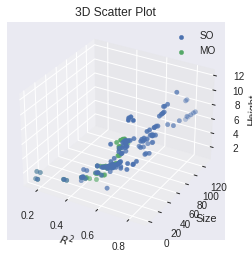

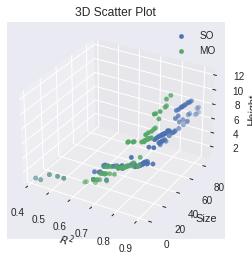

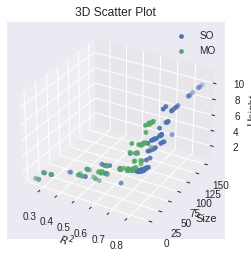

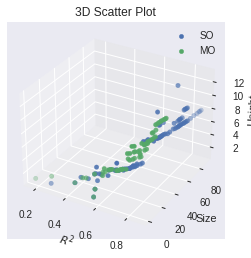

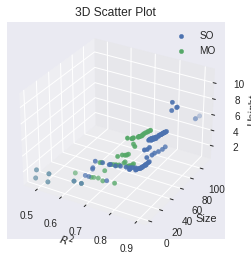

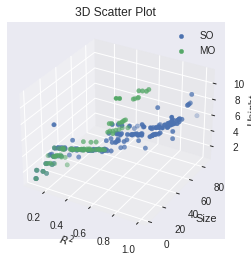

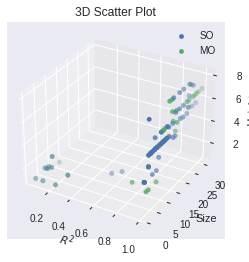

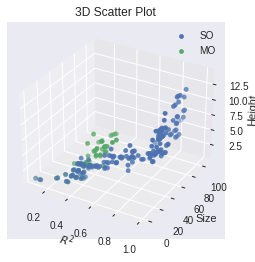

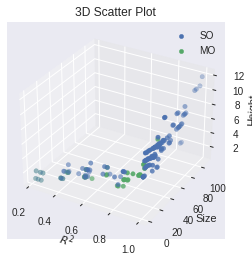

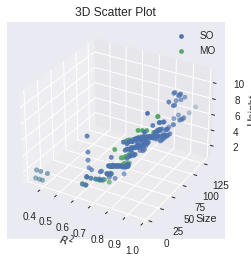

In [35]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

experiments = [["SO","MO"]]
for dataset in datasets:
    for experiment in experiments:
        # Create a new figure for 3D plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for algorithm in experiment:

            # Sample data
            x = dataset_filename[dataset][algorithm]["x"]
            y = dataset_filename[dataset][algorithm]["y"]
            z = dataset_filename[dataset][algorithm]["z"]



            # Create a 3D scatter plot
            ax.scatter(x, y, z, marker='o', label=algorithm)

        # Customize the plot (optional)
        ax.set_xlabel(r'$R^2$')
        ax.set_ylabel('Size')
        ax.set_zlabel('Height')
        ax.set_title('3D Scatter Plot')
        plt.legend()

        # Show the plot
        plt.show()

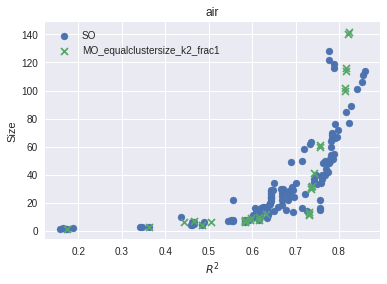

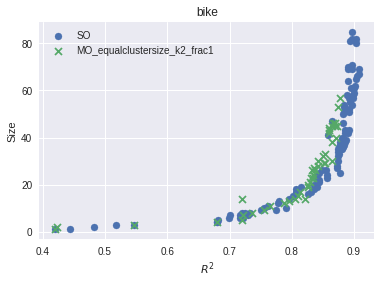

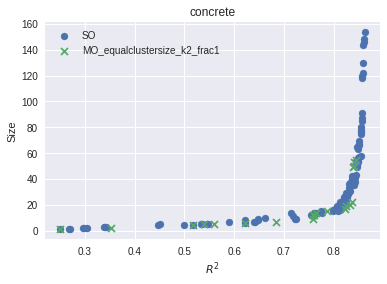

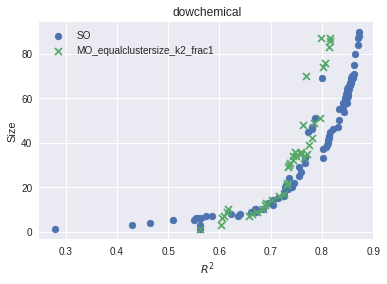

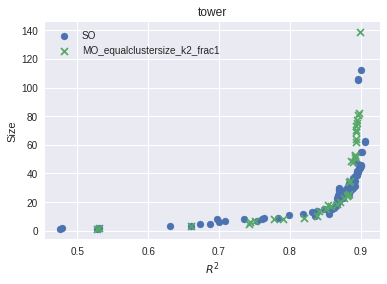

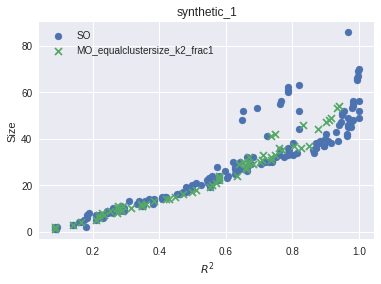

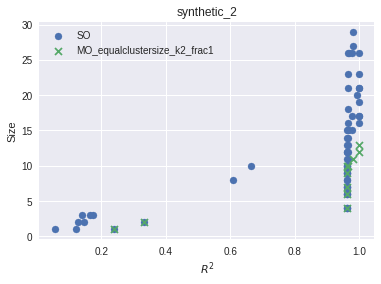

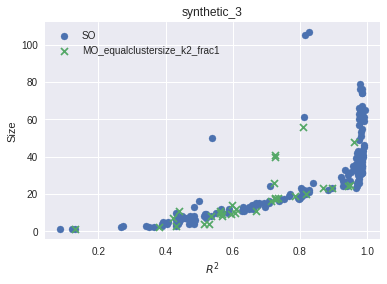

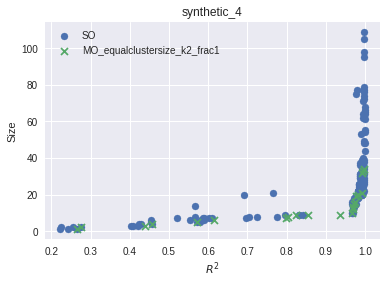

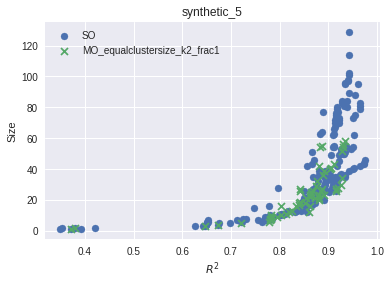

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

experiments = [["SO","MO_equalclustersize_k2_frac1"]]
markers = ['o', 'x', '^','s']
for dataset in datasets:
    for experiment in experiments:
        # Create a new figure for 3D plotting
        plt.figure()

        for algorithm in experiment:

            # Sample data
            x = dataset_filename[dataset][algorithm]["x"]
            y = dataset_filename[dataset][algorithm]["y"]

            # Create a 3D scatter plot
            plt.scatter(x, y, label=algorithm, marker=markers[experiment.index(algorithm)])

        # Customize the plot (optional)
        plt.xlabel(r'$R^2$')
        plt.ylabel('Size')
        plt.title(dataset)
        plt.legend()

        # Show the plot
        plt.show()
        